# Reflextion Actor

https://github.com/langchain-ai/langgraph/blob/main/examples/reflexion/reflexion.ipynb?ref=blog.langchain.dev

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U langchain-community tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "reflexion agent"

In [11]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="2023년 프로야구 우승팀은 누구인가요?"
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 최종 우승팀이 가려질 텐데, 그때까지 기다려 보는 게 좋겠네요. 지금까지의 성적과 전력으로 봤을 때 어떤 팀들이 유력할 것 같아요?

'안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 최종 우승팀이 가려질 텐데, 그때까지 기다려 보는 게 좋겠네요. 지금까지의 성적과 전력으로 봤을 때 어떤 팀들이 유력할 것 같아요?'

In [12]:
import operator
from typing import Annotated, List, Tuple, TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, List, Tuple, TypedDict, Literal, Sequence, Union

In [13]:
from langchain_core.pydantic_v1 import BaseModel, Field


In [14]:
selected_chat = 0
LLM_for_chat = [
  {
    "bedrock_region": "us-west-2", # Oregon
    "model_type": "claude3",
    "model_id": "anthropic.claude-3-sonnet-20240229-v1:0"
  }
]

In [15]:
def get_chat():
    global selected_chat
    
    profile = LLM_for_chat[selected_chat]
    bedrock_region =  profile['bedrock_region']
    modelId = profile['model_id']
    print(f'selected_chat: {selected_chat}, bedrock_region: {bedrock_region}, modelId: {modelId}')
                          
    # bedrock   
    boto3_bedrock = boto3.client(
        service_name='bedrock-runtime',
        region_name=bedrock_region,
        config=Config(
            retries = {
                'max_attempts': 30
            }
        )
    )
    parameters = {
        "max_tokens":maxOutputTokens,     
        "temperature":0.1,
        "top_k":250,
        "top_p":0.9,
        "stop_sequences": [HUMAN_PROMPT]
    }
    # print('parameters: ', parameters)

    chat = ChatBedrock(   # new chat model
        model_id=modelId,
        client=boto3_bedrock, 
        model_kwargs=parameters,
    )    
    
    selected_chat = selected_chat + 1
    if selected_chat == len(LLM_for_chat):
        selected_chat = 0
    
    return chat

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

In [17]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError

class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")

class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

In [18]:
class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

In [38]:
import datetime

system = """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer."""

user = """\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>"""

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        MessagesPlaceholder(variable_name="messages"),
        ("user",user),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)

initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | chat.bind_tools(tools=[AnswerQuestion])

validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [39]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond([HumanMessage(content=example_question)])

In [40]:
initial

AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 1967, 'completion_tokens': 296, 'total_tokens': 2263}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 1967, 'completion_tokens': 296, 'total_tokens': 2263}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-464b21ef-653d-4957-aead-ab55f14f6336-0', tool_calls=[{'name': 'AnswerQuestion', 'args': {'answer': "The original question asked why reflection is useful in AI systems. My initial answer covered several key reasons, including improving performance, explaining decisions, learning from mistakes, enabling self-awareness, and supporting ethical decision-making.\n\nTo illustrate with a concrete example, I described how a medical diagnosis AI could use reflection to analyze past cases where its diagnosis was incorrect, identify factors it missed or weighted improperly, and then adjust its diagnostic mo

In [27]:
initial.tool_calls

[{'name': 'AnswerQuestion',
  'args': {'answer': "Reflection is a valuable capability for AI systems as it allows them to evaluate their own performance, outputs, and decision-making processes. By reflecting, AI can identify strengths, weaknesses, and areas for improvement in order to continually refine and enhance its models, algorithms, and knowledge.\n\nOne key application of reflection in AI is in fields like robotics and autonomous systems, where self-monitoring and self-correction are critical. An AI agent controlling a robot or self-driving vehicle needs to constantly reflect on its actions, the environment around it, and potential consequences in order to make real-time adjustments and avoid hazards.\n\nReflection also supports continual learning for AI. As an AI system operates and encounters new data and situations, the ability to reflect on its current knowledge state allows it to pinpoint gaps and seek out additional information to expand its understanding.\n\nIn AI systems

In [55]:
query = "재미있게 사는 방법은?"
inputs = [HumanMessage(content=query)]

initial = first_responder.respond(inputs)

In [44]:
initial.tool_calls

[{'name': 'AnswerQuestion',
  'args': {'answer': '세상을 재미있게 사는 방법은 개인의 가치관과 삶의 목표에 따라 다릅니다. 그러나 일반적으로 다음과 같은 방법들이 도움이 될 수 있습니다:\n\n1. 긍정적인 마인드를 갖는 것이 중요합니다. 작은 일상의 기쁨을 발견하고 감사하는 자세를 갖는 것이 행복감을 높일 수 있습니다. \n\n2. 새로운 경험과 도전을 두려워하지 말고 열린 자세로 임하는 것이 좋습니다. 새로운 취미활동이나 여행 등을 통해 삶에 활력을 불어넣을 수 있습니다.\n\n3. 가족, 친구 등 주변인들과의 관계를 소중히 여기고 시간을 가지는 것도 중요합니다. 인간관계는 삶의 의미와 행복감을 높여줍니다.\n\n4. 건강한 생활습관을 갖는 것 또한 중요합니다. 운동, 균형 잡힌 식단, 충분한 수면 등이 신체와 정신 건강에 도움이 됩니다.\n\n5. 자신의 재능과 열정을 발견하고 그것을 계발하는 데 시간을 투자하는 것도 의미 있는 삶을 살아가는 데 도움이 됩니다.',
   'reflection': {'missing': '세상을 재미있게 사는 방법에 대한 구체적인 예시나 사례가 부족합니다. 또한 개인의 가치관과 삶의 목표에 따라 다를 수 있다는 점을 더 강조할 필요가 있습니다.',
    'superfluous': '대체로 적절한 답변이지만, 일부 내용이 너무 일반적이거나 당위적인 면이 있습니다.'},
   'search_queries': ['세상을 재미있게 사는 사람들의 사례',
    '개인의 가치관과 삶의 목표에 따른 행복한 삶의 방식',
    '일상 속 작은 기쁨을 발견하는 방법']},
  'id': 'toolu_bdrk_018mAde3jBA12JKaYVTWZp46',
  'type': 'tool_call'}]

In [47]:
tools = [AnswerQuestion]
model = chat.bind_tools(tools)

## Draft

In [425]:
class State(TypedDict):
    task: str
    messages: Annotated[list, add_messages]
    reflection: list
    search_queries: list

In [469]:
# query = "인생을 즐겁게 사는 방법은?"
# query = "베드민턴을 잘 치기 위해서 어떻게 해야하나?"
query = "카레이서가 되기 위해서는 어떤 과정을 거쳐야 하나요?"
#query = "Why is reflection useful in AI?"
#query =  "재미있게 사는 방법은?"

In [470]:
def generate_draft(state: State):
    message = [HumanMessage(content=state["task"])]
    
    system = """You are expert researcher.
    Provide a detailed ~250 word answer.."""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    chat = get_chat()

    chain = prompt | chat

    response = chain.invoke({
        "messages": message
    })
        
    return {
        "task": state["task"],
        "messages": [response]
    }

In [471]:
output_draft = generate_draft({"task": query})

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0


In [472]:
output_draft

{'task': '카레이서가 되기 위해서는 어떤 과정을 거쳐야 하나요?',
 'messages': [AIMessage(content='카레이서가 되기 위해서는 다음과 같은 과정을 거쳐야 합니다.\n\n1. 카팅 교육 이수\n카레이서가 되기 위해서는 전문 카팅 교육을 받아야 합니다. 카팅 교육에서는 레이싱 기술, 차량 관리, 안전 수칙 등을 배웁니다. 일반적으로 1년 이상의 교육 과정을 이수해야 합니다.\n\n2. 아마추어 레이스 참가\n카팅 교육을 마친 후에는 아마추어 레이스에 참가하여 실전 경험을 쌓아야 합니다. 아마추어 레이스에서 우수한 성적을 거두면 프로 레이싱팀의 주목을 받을 수 있습니다.\n\n3. 프로 레이싱팀 입단\n우수한 성적을 거둔 아마추어 레이서는 프로 레이싱팀에 입단할 기회를 얻게 됩니다. 프로 레이싱팀에 입단하면 전문적인 트레이닝과 지원을 받을 수 있습니다.\n\n4. 프로 레이스 참가\n프로 레이싱팀에 입단한 후에는 본격적으로 프로 레이스에 참가하게 됩니다. 프로 레이스에서 좋은 성적을 거두면 유명 레이서로 성장할 수 있습니다.\n\n따라서 카레이서가 되기 위해서는 전문 교육, 아마추어 레이스 경험, 프로 레이싱팀 입단, 프로 레이스 참가 등의 과정을 차근차근 밟아 나가야 합니다.', additional_kwargs={'usage': {'prompt_tokens': 57, 'completion_tokens': 566, 'total_tokens': 623}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 57, 'completion_tokens': 566, 'total_tokens': 623}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-b

## Extract reflection and search queries

In [473]:
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    advisable: str = Field(description="Critique of what is helpful for better answer")
    superfluous: str = Field(description="Critique of what is superfluous")

class Research(BaseModel):
    """Provide reflection and then follow up with search queries to improve the answer."""

    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

In [474]:
def research_draft(state: State):
    print('draft: ', state["messages"][-1].content)
    
    for attempt in range(5):
        chat = get_chat()
        structured_llm = chat.with_structured_output(Research, include_raw=True)
        
        info = structured_llm.invoke(state["messages"][-1].content)
        print('info: ', info)
            
        if not info['parsed'] == None:
            parsed_info = info['parsed']
            # print('reflection: ', parsed_info.reflection)                
            reflection = [parsed_info.reflection.missing, parsed_info.reflection.advisable]
            print('reflection: ', parsed_info.reflection)            
            print('search_queries: ', parsed_info.search_queries)
            break
    
    return {
        "task": state["task"],
        "messages": state["messages"],
        "reflection": reflection,
        "search_queries": parsed_info.search_queries
    }

In [475]:
output_research = research_draft(output_draft)

draft:  카레이서가 되기 위해서는 다음과 같은 과정을 거쳐야 합니다.

1. 카팅 교육 이수
카레이서가 되기 위해서는 전문 카팅 교육을 받아야 합니다. 카팅 교육에서는 레이싱 기술, 차량 관리, 안전 수칙 등을 배웁니다. 일반적으로 1년 이상의 교육 과정을 이수해야 합니다.

2. 아마추어 레이스 참가
카팅 교육을 마친 후에는 아마추어 레이스에 참가하여 실전 경험을 쌓아야 합니다. 아마추어 레이스에서 우수한 성적을 거두면 프로 레이싱팀의 주목을 받을 수 있습니다.

3. 프로 레이싱팀 입단
우수한 성적을 거둔 아마추어 레이서는 프로 레이싱팀에 입단할 기회를 얻게 됩니다. 프로 레이싱팀에 입단하면 전문적인 트레이닝과 지원을 받을 수 있습니다.

4. 프로 레이스 참가
프로 레이싱팀에 입단한 후에는 본격적으로 프로 레이스에 참가하게 됩니다. 프로 레이스에서 좋은 성적을 거두면 유명 레이서로 성장할 수 있습니다.

따라서 카레이서가 되기 위해서는 전문 교육, 아마추어 레이스 경험, 프로 레이싱팀 입단, 프로 레이스 참가 등의 과정을 차근차근 밟아 나가야 합니다.
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 1069, 'completion_tokens': 352, 'total_tokens': 1421}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 1069, 'completion_tokens': 352, 'total_tokens': 1421}, 'stop_reason': 'tool_use', 'model_id':

In [476]:
output_research

{'task': '카레이서가 되기 위해서는 어떤 과정을 거쳐야 하나요?',
 'messages': [AIMessage(content='카레이서가 되기 위해서는 다음과 같은 과정을 거쳐야 합니다.\n\n1. 카팅 교육 이수\n카레이서가 되기 위해서는 전문 카팅 교육을 받아야 합니다. 카팅 교육에서는 레이싱 기술, 차량 관리, 안전 수칙 등을 배웁니다. 일반적으로 1년 이상의 교육 과정을 이수해야 합니다.\n\n2. 아마추어 레이스 참가\n카팅 교육을 마친 후에는 아마추어 레이스에 참가하여 실전 경험을 쌓아야 합니다. 아마추어 레이스에서 우수한 성적을 거두면 프로 레이싱팀의 주목을 받을 수 있습니다.\n\n3. 프로 레이싱팀 입단\n우수한 성적을 거둔 아마추어 레이서는 프로 레이싱팀에 입단할 기회를 얻게 됩니다. 프로 레이싱팀에 입단하면 전문적인 트레이닝과 지원을 받을 수 있습니다.\n\n4. 프로 레이스 참가\n프로 레이싱팀에 입단한 후에는 본격적으로 프로 레이스에 참가하게 됩니다. 프로 레이스에서 좋은 성적을 거두면 유명 레이서로 성장할 수 있습니다.\n\n따라서 카레이서가 되기 위해서는 전문 교육, 아마추어 레이스 경험, 프로 레이싱팀 입단, 프로 레이스 참가 등의 과정을 차근차근 밟아 나가야 합니다.', additional_kwargs={'usage': {'prompt_tokens': 57, 'completion_tokens': 566, 'total_tokens': 623}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 57, 'completion_tokens': 566, 'total_tokens': 623}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-b

In [477]:
def retrieve(queries: list):
    content = []
    
    search = TavilySearchResults(k=2)
    for q in queries:
        response = search.invoke(q)     
        for r in response:
            content.append(r['content'])    
    
    return content

In [478]:
def revise_answer(state: State):
    system = """"Revise your previous answer using the new information.
You should use the previous critique to add important information to your answer. provide the final answer with <result> tag\
<critique>
{reflection}
</critique>

<information>
{content}
</information>"""
    
    content = retrieve(state['search_queries'])
    # print('content: ', content)    
                
    reflection_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
        
    chat = get_chat()
    reflect = reflection_prompt | chat
        
    messages = [HumanMessage(content=state["task"])] + state["messages"]
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    print('translated: ', translated)
        
    res = reflect.invoke(
        {
            "messages": translated,
            "reflection": state["reflection"],
            "content": content
        }
    )    
                            
    response = HumanMessage(content=res.content[res.content.find('<result>')+8:len(res.content)-9])
    
    return {"messages": [response]}

In [479]:
output_revise = revise_answer(output_research)

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
translated:  [HumanMessage(content='카레이서가 되기 위해서는 어떤 과정을 거쳐야 하나요?'), HumanMessage(content='카레이서가 되기 위해서는 다음과 같은 과정을 거쳐야 합니다.\n\n1. 카팅 교육 이수\n카레이서가 되기 위해서는 전문 카팅 교육을 받아야 합니다. 카팅 교육에서는 레이싱 기술, 차량 관리, 안전 수칙 등을 배웁니다. 일반적으로 1년 이상의 교육 과정을 이수해야 합니다.\n\n2. 아마추어 레이스 참가\n카팅 교육을 마친 후에는 아마추어 레이스에 참가하여 실전 경험을 쌓아야 합니다. 아마추어 레이스에서 우수한 성적을 거두면 프로 레이싱팀의 주목을 받을 수 있습니다.\n\n3. 프로 레이싱팀 입단\n우수한 성적을 거둔 아마추어 레이서는 프로 레이싱팀에 입단할 기회를 얻게 됩니다. 프로 레이싱팀에 입단하면 전문적인 트레이닝과 지원을 받을 수 있습니다.\n\n4. 프로 레이스 참가\n프로 레이싱팀에 입단한 후에는 본격적으로 프로 레이스에 참가하게 됩니다. 프로 레이스에서 좋은 성적을 거두면 유명 레이서로 성장할 수 있습니다.\n\n따라서 카레이서가 되기 위해서는 전문 교육, 아마추어 레이스 경험, 프로 레이싱팀 입단, 프로 레이스 참가 등의 과정을 차근차근 밟아 나가야 합니다.')]


In [480]:
output_revise["messages"][-1].content

'\n카레이서가 되기 위해서는 다음과 같은 과정을 거쳐야 합니다:\n\n1. 카팅 교육 이수\n- 전문 카팅 교육 기관에서 1년 이상의 교육 과정을 이수해야 함\n- 교육비용이 상당히 높은 편이며, 일반적으로 수백만원에서 천만원 이상 소요됨\n- 레이싱 기술, 차량 관리, 안전 수칙 등을 배움\n\n2. 아마추어 레이스 참가\n- 카팅 교육을 마친 후 아마추어 레이스에 참가하여 실전 경험 쌓음\n- 아마추어 레이스 참가 자격 요건을 충족해야 함 (예: 연령, 면허 등)\n- 우수한 성적을 거두면 프로 레이싱팀의 주목을 받을 수 있음\n\n3. 프로 레이싱팀 입단\n- 아마추어 레이스에서 우수한 성적을 거둔 레이서에게 기회가 주어짐\n- 프로 레이싱팀 입단 경쟁이 매우 치열함\n- 입단 시 전문적인 트레이닝과 지원을 받게 됨\n\n4. 프로 레이스 참가\n- 프로 레이싱팀에 입단한 후 본격적으로 프로 레이스에 참가\n- 프로 레이스에서 좋은 성적을 거두면 유명 레이서로 성장 가능\n\n따라서 전문 교육, 아마추어 레이스 경험, 프로팀 입단, 프로 레이스 참가 등 어려운 과정을 차근차근 밟아나가야 하며, 많은 노력과 인내심이 필요합니다.\n'

## Revision

In [23]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""

# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | chat.bind_tools(tools=[ReviseAnswer])

revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [29]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                tavily_tool.invoke(
                    {"query": initial.tool_calls[0]["args"]["search_queries"][0]}
                )
            ),
        ),
    ]
)
revised

AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 1859, 'completion_tokens': 648, 'total_tokens': 2507}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 1859, 'completion_tokens': 648, 'total_tokens': 2507}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-5384485a-0b0c-4757-8cbd-becd3f1163b3-0', tool_calls=[{'name': 'ReviseAnswer', 'args': {'answer': "Reflection is a crucial capability for AI systems as it enables them to evaluate their own performance, outputs, and decision-making processes in order to continually improve and enhance their models and knowledge. Some key applications of reflection in AI include:\n\n1) Self-monitoring and self-correction for robotics and autonomous systems like self-driving cars, which need to constantly reflect on their actions, environment, and potential consequences to make real-time adjustments and avoid hazar

### Create Tool Node

In [31]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

### Construct Graph

In [32]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

MAX_ITERATIONS = 5

builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)
builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)

# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:
def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i

def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

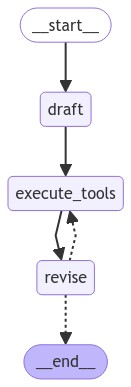

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [35]:
events = graph.stream(
    [HumanMessage(content="How should we handle the climate crisis?")],
    stream_mode="values",
)

In [34]:

for i, step in enumerate(events):
    print(f"Step {i}")
    step[-1].pretty_print()

InvalidUpdateError: Expected dict, got [HumanMessage(content='How should we handle the climate crisis?')]

## State

In [16]:
class State(TypedDict):
    task: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [17]:
def generation(state: State):    
    system = """You are expert researcher. 
Provide a detailed ~250 word answer."""
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}")
        ]
    )
        
    chat = get_chat()
    chain = prompt | chat

    response = chain.invoke(state['task'])
    # print('response: ', response)
        
    return {"draft": response.content}

In [18]:
output_draft = generation({"task":"서울에서 제주를 거쳐서 대전으로 가는 가장 빠른 방법과 교통편을 알려주세요."})

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0


In [19]:
output_draft

{'draft': '서울에서 제주를 거쳐 대전으로 가는 가장 빠른 방법은 항공편을 이용하는 것입니다. 구체적인 경로는 다음과 같습니다:\n\n1. 서울에서 제주까지 항공편 이용\n- 서울에서 제주국제공항까지 약 1시간 10분 소요\n\n2. 제주에서 대전까지 항공편 이용 \n- 제주국제공항에서 대전국제공항까지 약 1시간 소요\n\n이렇게 하면 총 소요시간은 약 2시간 10분 정도가 됩니다. \n\n항공편을 이용하면 가장 빠르고 편리하게 이동할 수 있지만, 비용이 다소 높은 편입니다. 예약 상황에 따라 가격 변동이 있겠지만, 왕복 항공권 가격은 대략 20만원에서 30만원 사이일 것으로 예상됩니다.\n\n시간적 여유가 있다면 대중교통을 이용하는 것도 고려해볼 수 있습니다. 서울에서 제주까지는 배편을 이용하고, 제주에서 대전까지는 항공편을 이용하는 방법이 있습니다. 하지만 이 경우 이동 시간이 10시간 이상 소요되므로 시간을 많이 투자해야 합니다.'}

## Reflection

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults
import json

In [21]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    """List of quries as a json format"""

    queries: str = Field(description="queries relevant to the question'")

In [22]:
def reflection(state: State):
    system = """You are a researcher charged with providing information that can \
be used when writing the following answer. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max. All queries should be words or string without numbers"""
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{answer}"),
        ]
    )
        
    chat = get_chat()
    chain = prompt | chat

    response = chain.invoke({"answer": state['draft']})
    print('response: ', response.content)
    
    chat = get_chat()
    structured_llm = chat.with_structured_output(Queries, include_raw=True)
    info = structured_llm.invoke(response.content)
    print('info: ', info)
    
    content = []
    if not info['parsed'] == None:
        queries = info['parsed']
        print('queries: ', queries.queries)
    
        search = TavilySearchResults(k=2)
        for q in json.loads(queries.queries):
            # print('q: ', q)
            
            response = search.invoke(q)     
            # print('response: ', response)        
            for r in response:
                content.append(r['content'])    
    return {
        "content": content,
        "draft": state["draft"]
    }

In [23]:
output_reflection = reflection(output_draft)

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  1. 서울 제주 항공편
2. 제주 대전 항공편
3. 서울 제주 대전 이동 경로
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 371, 'completion_tokens': 109, 'total_tokens': 480}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 371, 'completion_tokens': 109, 'total_tokens': 480}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-1c951a56-d1e4-46fc-9c2b-5b5b161e2b11-0', tool_calls=[{'name': 'Queries', 'args': {'queries': '[\n  "서울에서 제주까지 가는 항공편",\n  "제주에서 대전까지 가는 항공편", \n  "서울에서 제주를 경유하여 대전까지 가는 이동 경로"\n]'}, 'id': 'toolu_bdrk_01Ea9ETTtddmZ8JFHRqsouXF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 109, 'total_tokens': 480}), 'parsed': Querie

In [24]:
output_reflection

{'content': ['서울에서 제주으로 가는 실시간 항공편을 확인하고, 최저가 서울 제주 항공권을 트립닷컴에서 예약하세요! ... 서울에서 제주까지 운행하는 직항 항공편은 대부분 김포국제공항에서 출발하는데, 김포국제공항 출발 제주국제공항 도착 항공편 기준 평균 비행 ...',
  "편도 항공편 - 운항사: 티웨이 항공. 12월 3일 (화) 서울 김포에서 출발하여 제주공항에 도착하는 출국 직항 항공편 - 운항사: 티웨이 항공. ... 서울에서 제주공항까지 가는 직항 항공편만 보고 싶으세요? 검색할 때 '직항만'에 체크하세요.",
  '지난 1년간의 항공편 데이터를 바탕으로 서울에서 제주시(으)로 떠날 최적의 시기를 알아 보세요. 가장 저렴한 월별 및 요일별 항공편을 찾아보세요. ... 서울발 제주시행 항공편 예약 시 kayak 사용자에게 가장 인기 있는 항공사는 대한항공 및 아시아나항공입니다 ...',
  '제주도행 일반석 항공권. 38,334원. 서울 김포 국제공항발 제주도행 항공편: 78,036원. 인천 국제 공항발 제주도행 항공편: 38,334원. 제주시 제주시 행 항공편. 제주도 도착 36,965원 출발 항공권을 찾아보세요. Fly $ [35982,city, 서울 출발 에어부산, 진에어, 티웨이항공 ...',
  '서울(SEL)출발 제주(CJU)도착 익스피디아 항공권 특가! 편도 {flightsLowestPriceOW}~, 왕복 {flightsLowestPrice} ~. 실시간으로 저렴한 항공권 가격 비교부터 즉시 예약, 결제까지 한 번에. 전세계 항공권은 익스피디아!',
  '대전여행 가는길 -서귀포버스터미널 800번 리무진- 경유지 : 서귀포버스터미널→ 유승한내들아파트→ 공무원연금공단→ 서귀포시청2청사→ 강창학구장→ 농업기술원→ 법화사→ 회수사거리→ 정든마을→ 롯데마트→ 신제주로타리→ 제주국제공항→ 제주터미널',
  'Flights from Rach Gia to Kuala Lumpur 편도 expand_more 1 승객 expand_more 출발지

In [48]:
def revise_answer(state: State):   
    system = """Revise your previous answer using the new information as bellow. Then prvide the final answer with <result> tag.
    
    <information>
    {content}
    </information
    """
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "<answer>{draft}</answer>"),
        ]
    )
            
    chat = get_chat()
    chain = prompt | chat

    response = chain.invoke({
        "content": state['content'],
        "draft": state['draft']
    })
    print('response: ', response)
            
    revision_number = state["revision_number"] if state.get("revision_number") is not None else 1
    return {
        "draft": response, 
        "revision_number": revision_number + 1
    }

In [49]:
output_revise = revise_answer(output_reflection)

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  content='제공된 정보를 종합하여 수정된 답변은 다음과 같습니다:\n\n<result>\n서울에서 제주를 거쳐 대전으로 가는 가장 빠른 방법은 다음과 같습니다:\n\n1. 서울 김포공항에서 제주국제공항까지 직항 항공편 이용 (약 1시간 소요)\n2. 제주국제공항에서 대전국제공항까지 직항 항공편 이용 (약 1시간 소요)\n\n총 소요시간은 약 2시간 정도입니다. 항공권 가격은 출발지, 항공사, 시기에 따라 다르지만 대략 서울-제주 편도 4만원 내외, 제주-대전 편도 4만원 내외로 왕복 총 16만원 정도가 예상됩니다.\n\n대중교통을 이용할 경우 서울에서 제주까지는 배편, 제주에서 대전까지는 항공편을 이용하는 방법이 있지만 이동 시간이 10시간 이상 소요되므로 시간이 많이 걸립니다.\n</result>' additional_kwargs={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-d75927d3-60ec-49b2-b8cb-5d38d9470366-0' usage_metadata={'input_tokens': 2624, 'output_tokens': 371, 'total_tokens': 2995}

In [50]:
output_revise

{'draft': AIMessage(content='제공된 정보를 종합하여 수정된 답변은 다음과 같습니다:\n\n<result>\n서울에서 제주를 거쳐 대전으로 가는 가장 빠른 방법은 다음과 같습니다:\n\n1. 서울 김포공항에서 제주국제공항까지 직항 항공편 이용 (약 1시간 소요)\n2. 제주국제공항에서 대전국제공항까지 직항 항공편 이용 (약 1시간 소요)\n\n총 소요시간은 약 2시간 정도입니다. 항공권 가격은 출발지, 항공사, 시기에 따라 다르지만 대략 서울-제주 편도 4만원 내외, 제주-대전 편도 4만원 내외로 왕복 총 16만원 정도가 예상됩니다.\n\n대중교통을 이용할 경우 서울에서 제주까지는 배편, 제주에서 대전까지는 항공편을 이용하는 방법이 있지만 이동 시간이 10시간 이상 소요되므로 시간이 많이 걸립니다.\n</result>', additional_kwargs={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-d75927d3-60ec-49b2-b8cb-5d38d9470366-0', usage_metadata={'input_tokens': 2624, 'output_tokens': 371, 'total_tokens': 2995}),
 'revision_number': 2}

In [51]:
def should_continue(state: State, config):
        max_revisions = config.get("configurable", {}).get("max_revisions", MAX_REVISIONS)
        print("max_revisions: ", max_revisions)
            
        if state["revision_number"] > max_revisions:
            return "end"
        return "contine"

## Create the Graph

In [52]:
from langgraph.graph import START, END, StateGraph

In [53]:
workflow = StateGraph(State)

workflow.add_node("generation", generation)
workflow.add_node("reflection", reflection)
workflow.add_node("revise_answer", revise_answer)

workflow.set_entry_point("generation")

workflow.add_conditional_edges(
    "revise_answer", 
    should_continue, 
    {
        "end": END, 
        "contine": "reflection"}
)

workflow.add_edge("generation", "reflection")
workflow.add_edge("reflection", "revise_answer")

# graph = builder.compile(checkpointer=memory)

In [54]:
app = workflow.compile()

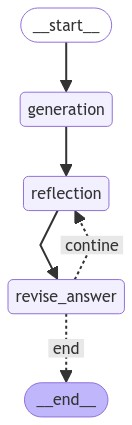

In [55]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## RUN

In [56]:
MAX_REVISIONS = 2
    
inputs = {"task": "How should we handle the climate crisis?"}
config = {
        "recursion_limit": 50,
        "max_revisions": 2
}

for output in app.stream(inputs, config=config):
    for key, value in output.items():
        print(f"Finished: {key}")

print("Final: ", value["draft"])

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
Finished: generation
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  Here are three potential search queries to gather relevant information for the detailed response:

1. "climate change mitigation strategies"
2. "renewable energy transition plans"
3. "carbon pricing policies climate change"
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 371, 'completion_tokens': 52, 'total_tokens': 423}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 371, 'completion_tokens': 52, 'total_tokens': 423}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-ff06c0c3-5f2c-4bab-ad4a-3f0beebd05a8-0', tool_calls=[{'

In [57]:
value['draft'].content

'The summary you provided in the <result> tag covers the key strategies for climate change mitigation and adaptation very well. It highlights the need for a multi-pronged approach involving transitioning to renewable energy, improving energy efficiency, protecting carbon sinks, developing carbon capture technologies, putting a price on emissions, building resilient infrastructure, developing drought-resistant agriculture, managed retreat from high-risk areas, providing financing and technology transfer to developing nations, and unprecedented global cooperation. The goal of dramatically reducing net greenhouse gas emissions to near zero by mid-century to limit the worst climate impacts is also clearly stated. This is a comprehensive and well-structured summary of the main strategies needed to tackle the climate crisis.'

In [58]:
inputs = {"task": "생성형 AI를 이용해 공장의 생산성을 높이는 방법은?"}
config = {
        "recursion_limit": 50,
        "max_revisions": 2
}

for output in app.stream(inputs, config=config):
    for key, value in output.items():
        print(f"Finished: {key}")

print("Final: ", value["draft"])

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
Finished: generation
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  생성형 AI를 활용하여 공장의 생산성을 높이는 방법에 대한 정보를 수집하기 위해 다음과 같은 검색어를 사용할 수 있습니다.

1. "AI factory productivity"
2. "predictive maintenance AI manufacturing"
3. "AI vision quality control manufacturing"
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 423, 'completion_tokens': 51, 'total_tokens': 474}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 423, 'completion_tokens': 51, 'total_tokens': 474}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-46696ea2-a0f2-4dad-afe5-4e6172c57273-0', tool_calls=[{'name': 'Queries', 'args': {'queries

In [59]:
value['draft'].content

'요약하신 내용이 매우 포괄적이고 잘 정리되어 있습니다. 생성형 AI가 제조업에서 예측 분석, 예지 정비, 품질 관리, 자동화, 가상 시뮬레이션 등 다양한 측면에서 생산성과 효율성을 높일 수 있는 방안을 잘 제시하셨습니다. 제가 추가할 내용은 없으며, 제시하신 답변이 완벽하다고 생각합니다.'